 <img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P4: Anticipez les besoins en consommation de bâtiments </span></font> </center>  

***

 <font size="4"> <span style="font-size: 1.5em" > **Partie 2: Machine Learning** </span> </font>  

**Contexte**  
La ville de Seattle veut atteindre son objectif de **ville neutre en émissions de carbone en 2050**. Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir.  
<img src="Seattle.png">
**Mission**  
* A partir des relevés déjà réalisés, **prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.   
* **Evaluer l’intérêt de l’"ENERGY STAR Score"** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. 

**1. Réaliser une courte analyse exploratoire.**  
**2. Tester différents modèles de prédiction afin de répondre au mieux à la problématique.**

La première partie nous a permis de réaliser un nettoyage des données et une courte analyse exploratoire. Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires et non-linéaires afin de : 
* prédire les consommations d'énergie des bâtiments;
* prédire les émissions de CO2;
* évaluer l'intérêt de 'ENERGY STAR Score' pour la prédiction.

 <font size="4"> <span style="font-size: 1.5em" > **Partie 2.2: Prédiction des emissions 'TotalGHGEmissions'** </span> </font>  

Ce notebook sera dédié à la prédiction des émissions 'TotalGHGEmissions' et à évaluation de l'intérêt de 'ENERGY STAR Score' pour cette prédiction. 

## Importation des librairies Python 

In [1]:
#------------------------------------------
# projet : Anticipez les besoins en consommation de bâtiments de la ville de Seattle
# Auteur : Rim BAHROUN
# Date: Descembre 2022
# OpenClassrooms
#-------------------------------------------
# importation des librairies Python pour DS
#-------------------------------------------
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn import metrics

import seaborn as sns

# import plotly.express as px

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# from sklearn.base import clone
from sklearn.kernel_ridge import KernelRidge

from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import RFE

import timeit
# import shap

## Fonctions utiles pour la suite

In [2]:
# Définition de quelque fonction utile pour la suite
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(12,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", metrics.r2_score(y, predictions))     
    
def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns    


def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 0
    kfold = KFold(n_splits=10, shuffle=False)#, , random_state=seed)#5 
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model

In [3]:
#pour afficher 165 colonnes ou lignes minimum
pd.set_option('display.max_column', 165) 
pd.set_option('display.max_row', 165) 

## Importation des données 

In [4]:
# importation des données
data_Seattle = pd.read_csv('data_cleaned.csv')

In [5]:
data = data_Seattle.copy()
data.shape

(1513, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PrimaryPropertyType  1513 non-null   object 
 1   CouncilDistrictCode  1513 non-null   object 
 2   NumberofFloors       1513 non-null   int64  
 3   PropertyGFATotal     1513 non-null   int64  
 4   ENERGYSTARScore      983 non-null    float64
 5   SiteEnergyUse(kBtu)  1513 non-null   float64
 6   TotalGHGEmissions    1513 non-null   float64
 7   Agebuilding          1513 non-null   int64  
 8   NaturalGas_use       1513 non-null   int64  
 9   Electricity_use      1513 non-null   int64  
 10  Steam_use            1513 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 130.1+ KB


In [7]:
data.drop(columns=['CouncilDistrictCode'], inplace=True)

Les résultats sans la variable 'CouncilDistrictCode' sont meilleurs. J'ai décidé de la supprimer pour la suite.  

# Preprocessing

Pour les données catégorielles, nous allons devoir encoder les valeurs. J'utiliserai dans la suite 'get_dummies' qui convertie les fariables catégorielles en variables numériques binaires 0/1.

## Encodage

In [8]:
data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          236
Warehouse                      185
Large Office                   168
Mixed Use Property             109
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

In [9]:
categoricals = ['PrimaryPropertyType']#
data = pd.get_dummies(data, columns=categoricals, prefix=[''])
data.head()

,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,12,88434,60.0,7226362.5,249.98,89,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11,103566,61.0,8387933.0,295.86,20,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41,956110,43.0,72587024.0,2089.28,47,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,61320,56.0,6794584.0,286.43,90,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,175580,75.0,14172606.0,505.01,36,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
data.shape

(1513, 30)

## Split into X and y

La variable 'TotalGHGEmissions' passera en y comme variable target pour ce notebook.
En premier lieu, l'ENERGYSTARScore sera écarté du dataset pour la prédiction des émissions. L'intérêt de cette variable sera étudié à la fin de ce notebook.  
Nous supprimerons égalent la variable 'SiteEnergyUse(kBtu)' qui est notre première target. Le reste des variables formera notre matrice de données X de dimension 1513 lignes et 27 colonnes.

In [11]:
y = data['TotalGHGEmissions']
X_ = data.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'ENERGYSTARScore'], axis=1)

In [12]:
X_

,NumberofFloors,PropertyGFATotal,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,12,88434,89,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11,103566,20,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41,956110,47,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,61320,90,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,175580,36,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,1,18261,34,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1509,1,16000,12,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1510,1,13157,42,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1511,1,14101,27,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Train and test sets 

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test (30% des données).

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0, test_size=0.3)

In [14]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ' , X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1059, 27)
y_train.shape =  (1059,)
X_test.shape =  (454, 27)
y_test.shape =  (454,)


**Entrainement**: 1059 lignes,  
**Test**: 454 lignes.

In [15]:
X_train

,NumberofFloors,PropertyGFATotal,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
411,1,107930,23,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
546,4,77412,12,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
249,1,123061,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1124,1,27760,100,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
871,1,35289,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2,92080,52,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
835,2,21128,57,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1216,4,42804,116,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
559,1,74178,58,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Standardisation

Les données numériques ('NumberofFloors', 'PropertyGFATotal', 'Agebuilding') doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un centrage-réduction via la méthode StandardScaler de Scikit-Learn.

In [16]:
# Rescale the input features
columns_to_scale = X_.columns[:3]
coumns_not_to_scale = X_.columns[3:]

scaler = StandardScaler()

X_train_scaled_ = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled_ = scaler.transform(X_test[columns_to_scale])

X_train_scaled = pd.DataFrame(X_train_scaled_, columns=columns_to_scale)
X_test_scaled = pd.DataFrame(X_test_scaled_, columns=columns_to_scale)

In [17]:
X_train_not_to_scale = X_train[coumns_not_to_scale]
X_test_not_to_scale = X_test[coumns_not_to_scale]

In [18]:
X_train_not_to_scale.reset_index(inplace=True, drop=True)
X_test_not_to_scale.reset_index(inplace=True, drop=True)

In [19]:
X_train = pd.merge(X_train_scaled, X_train_not_to_scale, left_index =True, right_index = True)
X_train.shape

(1059, 27)

In [20]:
X_test = pd.merge(X_test_scaled, X_test_not_to_scale, left_index =True, right_index = True)
X_test.shape

(454, 27)

In [21]:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [22]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ' , X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (1059, 27)
y_train.shape =  (1059,)
X_test.shape =  (454, 27)
y_test.shape =  (454,)


# Modélisation

Nous allons calculer 3 métriques pour évaluer nos modèles :

* MAE : Mean Absolute Error.   
La MAE, ou erreur absolue moyenne, est la moyenne des valeurs absolues des erreurs.
\begin{equation*}
MAE =  \frac{1}{n} \sum_{i=1}^n |y_i – \hat{y}_i|
\end{equation*}
La MAE est dans la même unité que la variable à prédire. Par conséquent, elle est facile à interpréter.
Cette métrique quantifie l’erreur réalisée par le modèle. Plus elle est élevée, moins le modèle est performant.  
La MAE pénalise autant les grandes erreurs que les petites erreurs, contrairement à la RMSE.
Du fait de l’utilisation d’une valeur absolue dans la somme, une erreur 3 fois plus grande aura 3 fois plus d’impact sur l’erreur. Cette métrique est sensible aux outliers. L’observation d’une valeur aberrante pénalise le modèle, mais moins que pour la RMSE.  

* RMSE : Root Mean Squared Error.  
La RMSE est la racine de l’erreur quadratique moyenne.
\begin{equation*} RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i – \hat{y}_i)^2} \end{equation*}

La RMSE pénalise plus fortement les grandes erreurs que les petites. Etant donné le carré dans la somme, une erreur 3 fois plus grande aura 9 fois plus d’impact sur la moyenne. Par conséquent elle est très sensible aux outliers.
Les outliers sont des points pour lesquels la valeur réelle est aberrante. La prédiction sera donc souvent très éloignée de cette valeur aberrante, ce qui accroît fortement la contribution des individus outliers dans cette métrique.

* R² : Coeficient de détermination, carré du coefiscient de corrélation linéaire.  
\begin{equation*} R^2 = 1 - \frac{\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{n}{(y_i-\bar{y})^2}} \end{equation*}

Plus le $R^2$ est proche de 1 meilleur est notre prédiction. Le coefficient de détermination nous indique à quel point les valeurs prédites sont corrélées aux vraies valeurs. 

Avec 
* $y_i$: valeure réelle  
* $\hat{y}_i$: valeure prédite
* $\bar{y}$: valeure moyenne


## Baseline: DummyRegressor

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliorent les prédictions. Pour cette baseline, nous utiliserons une prédiction par la moyenne avec un **DummyRegressor**.

In [23]:
# Build and evaluate a dummy regression model 

# Create model
name_reg = 'DummyRegressor'
model = DummyRegressor()

# Fit model
model.fit(X_train, y_train)

# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate
df_Result = pd.DataFrame({})
df_Result.loc[name_reg,'R2_train'] = round(model.score(X_train, y_train),2) # coéfficient de détermination
df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)

df_Result

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test
DummyRegressor,0.0,-0.0,629.771874,424.776008,193.08442,181.931111


## Régression linéaire simple

En premier lieu, nous s'intéresserons à l'étude d'un modèle de régression linéaire simple.  

### Prédiction sans cross-validation

Train set:
    R2 0.6601731622715372
Test set:
    R2 0.5370543799444478


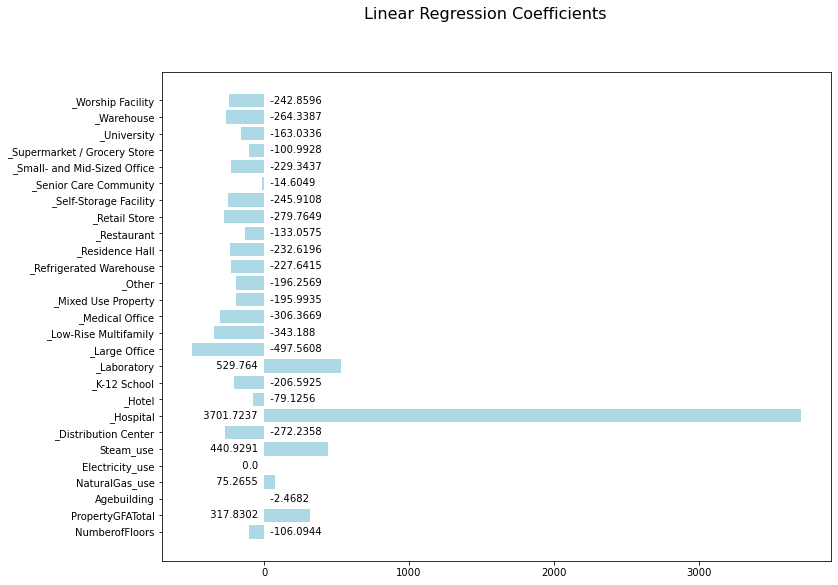

In [24]:
# Build and evaluate a linear regression model 

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)
print("Train set:")
score(model, X_train, y_train)

# Evaluate
print("Test set:")
score(model, X_test, y_test)

# Summary
linearRegressionSummary(model, X_train.columns)#.regressor_

Le modèle linéaire simple donne de bonne résultat sur le train et le test set.   
L'étude de l'importance des variables dans la prédiction, montre que les variables 'Hospital', 'Laboratory', 'Steam_Use' et surface du bâtiment 'PropertyGFATotal' sont les plus importantes pour ce modèle. Ce résultat est attendu vu que les émissions dépendent de la surface et elles sont beaucoup plus importantes pour les Hôpitaux et les laboratoires.   
Dans la suite, on étudera la stabilité de notre modèle par rapport au choix de Train/Test dans le jeu de données. 

### Prédiction avec cross-validation 

In [25]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X_train, y_train)

# I will evaluate using the train set
print("Train set")
score(model, X_train, y_train)

# I will evaluate using the test set
print("Test set")
score(model, X_test, y_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [-0.37809998 -0.22713558 -1.0594658   0.26273805 -1.07938378  0.74521301
 -3.81534409 -0.35641528  0.83781982  0.67418132]
    Mean R2 score: -0.4395892320046471
    Std R2 score: 1.3043933063021682
Train set
    R2 0.6601731622715372
Test set
    R2 0.5370543799444478


Le modèle n'est pas stable par rapport au découpage train/test. Ce là est dû à la taille de notre jeu de données et la présence de quelque bâtiments (hôpitaux et laboratoires) qui émisent beaucoup par rapport au reste des bâtiements. Pour valider cette justification, nous testerons le K-Fold avec un jeu de données sans les hôpitaux et les laboratoires.  

In [26]:
Xy_train = X_train.copy() 
Xy_train['Y'] = y_train
Xy1_train = Xy_train.loc[(Xy_train['_Hospital']==0)&(Xy_train['_Laboratory']==0),:]
Xy1_train.reset_index(inplace=True, drop=True)
X1_train = Xy1_train.iloc[:,:-1] 
y1_train = Xy1_train.iloc[:,-1:] 

Xy_test = X_test.copy() 
Xy_test['Y'] = y_test
Xy1_test = Xy_test.loc[(Xy_test['_Hospital']==0)&(Xy_test['_Laboratory']==0),:]
Xy1_test.reset_index(inplace=True, drop=True)
X1_test = Xy1_test.iloc[:,:-1] 
y1_test = Xy1_test.iloc[:,-1:] 

In [27]:
print('X1_train.shape = ', X1_train.shape)
print('y1_train.shape = ', y1_train.shape)
print('X1_test.shape = ' , X1_test.shape)
print('y1_test.shape = ',y1_test.shape)

X1_train.shape =  (1045, 27)
y1_train.shape =  (1045, 1)
X1_test.shape =  (448, 27)
y1_test.shape =  (448, 1)


In [28]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X1_train, y1_train)

# # I will evaluate using the train set
# print("Train set")
# score(model, X1_train, y1_train)

# # I will evaluate using the test set
# print("Test set")
# score(model, X1_test, y1_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [0.14082557 0.50313096 0.33027697 0.42533757 0.28103665 0.44654785
 0.46325554 0.20562921 0.53109723 0.38376861]
    Mean R2 score: 0.37109061665514187
    Std R2 score: 0.12267980218941936


La stabilité du modèle vis à vis au découpage Train/test est meilleure. Comme nous souhaitons prédire la consommation indépendamment du type d'utilisation. On gardera dans la suite tous les bâtiments quelque soit leur consommation. 

### Sélection de variables par un  RFE

RFE: Recursive Feature Elimination. Sélectionner automatiquement les variables pertinentes pour une régression linéaire. Le but de l'élimination récursive des caractéristiques (RFE) est de sélectionner les caractéristiques en considérant de manière récursive des ensembles de plus en plus petits de caractéristiques. Tout d'abord, l'estimateur est entraîné sur l'ensemble initial de caractéristiques et l'importance de chaque caractéristique est obtenue par le biais d'un attribut spécifique ou d'un appel. Ensuite, les caractéristiques les moins importantes sont élaguées de l'ensemble actuel de caractéristiques. Cette procédure est répétée de manière récursive sur l'ensemble élagué jusqu'à ce que le nombre souhaité de caractéristiques à sélectionner soit finalement atteint.

In [29]:
# Build models using from 1 to n-1 features
for i in range(1, X_train.shape[1]+1):
    print("\nRFE ", i, end="\t")
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    rfe = RFE(model, n_features_to_select = i)
    rfe.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Evaluate using k-fold cross-validation
    model = kFoldCV(X_train_rfe, y_train, silent=True)
    predictions = model.predict(X_test_rfe)
    print("R2", metrics.r2_score(y_test, predictions)) 


RFE  1	R2 0.5262537747287318

RFE  2	R2 0.5226301512088887

RFE  3	R2 0.5503492075376317

RFE  4	R2 0.5501642589361189

RFE  5	R2 0.551185001954843

RFE  6	R2 0.5511558351041308

RFE  7	R2 0.5441612977917658

RFE  8	R2 0.5444966450990523

RFE  9	R2 0.547662883619769

RFE  10	R2 0.551102911286401

RFE  11	R2 0.5494584867405543

RFE  12	R2 0.5493376841140931

RFE  13	R2 0.5507068777172244

RFE  14	R2 0.5520747989106922

RFE  15	R2 0.5523851411836673

RFE  16	R2 0.5526145277105268

RFE  17	R2 0.5539257543141564

RFE  18	R2 0.5622377794899232

RFE  19	R2 0.5343522648293961

RFE  20	R2 0.5347104242817462

RFE  21	R2 0.5368093834098293

RFE  22	R2 0.5367481502872644

RFE  23	R2 0.5366391967044413

RFE  24	R2 0.537088277041355

RFE  25	R2 0.5370882770413505

RFE  26	R2 0.5370543799444478

RFE  27	R2 0.5370543799444478


Le meilleur score $R^2$ est obtenu avec 18 variables. Gardons que ces 18 variables et évaluons notre modèle. 

In [30]:
# Create a model
model = LinearRegression()

# Select the best features according to RFE
rfe = RFE(model, n_features_to_select = 18)
rfe.fit(X_train, y_train)

selected_features = list(X_train.columns[rfe.support_])
print("Feature selection", rfe.support_)
print("Feature ranking", rfe.ranking_)
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~rfe.support_]))

Feature selection [False  True False False False  True  True  True False  True  True  True
  True  True  True  True  True  True False  True  True False  True False
 False  True  True]
Feature ranking [ 2  1  9  4 10  1  1  1  7  1  1  1  1  1  1  1  1  1  5  1  1  8  1  6
  3  1  1]
Selected features: ['PropertyGFATotal', 'Steam_use', '_Distribution Center', '_Hospital', '_K-12 School', '_Laboratory', '_Large Office', '_Low-Rise Multifamily', '_Medical Office', '_Mixed Use Property', '_Other', '_Refrigerated Warehouse', '_Residence Hall', '_Retail Store', '_Self-Storage Facility', '_Small- and Mid-Sized Office', '_Warehouse', '_Worship Facility']
Removed features: ['NumberofFloors', 'Agebuilding', 'NaturalGas_use', 'Electricity_use', '_Hotel', '_Restaurant', '_Senior Care Community', '_Supermarket / Grocery Store', '_University']


Le meilleur score $R^2$ est obtenu avec un modèle utilisant uniquement 3 variables: 'Hospital', 'Laboratory' et surface du bâtiment 'PropertyGFATotal'. Ce résultat confirme l'analyse d'importance des variables déjà effectué.

In [31]:
# Transform (remove features not selected)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

Nous effectuons une prédiction en utilisant uniquement les 18 variables sélectionnées par la RFE et nous regarderons les performances de notre modèle. 

In [32]:
selected_features

['PropertyGFATotal',
 'Steam_use',
 '_Distribution Center',
 '_Hospital',
 '_K-12 School',
 '_Laboratory',
 '_Large Office',
 '_Low-Rise Multifamily',
 '_Medical Office',
 '_Mixed Use Property',
 '_Other',
 '_Refrigerated Warehouse',
 '_Residence Hall',
 '_Retail Store',
 '_Self-Storage Facility',
 '_Small- and Mid-Sized Office',
 '_Warehouse',
 '_Worship Facility']

In [33]:
# Build and evaluate a linear regression model with the reduced feature set
model = kFoldCV(X_train_rfe, y_train)

print("Train set:")
score(model, X_train_rfe, y_train)

print("Test set:")
score(model, X_test_rfe, y_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [-0.30357634 -0.23617248 -0.79170687  0.31140729 -0.55004676  0.72686136
 -4.13605072 -0.23323988  0.8332566   0.6600563 ]
    Mean R2 score: -0.3719211510631109
    Std R2 score: 1.3642083062906476
Train set:
    R2 0.6455133626062455
Test set:
    R2 0.5622377794899232


Les résultats ne sont pas bonnes sur l'ensemble du jeux de données. On garde nos 27 variables initiales pour la suite. 

# Modèles 

## Avec optimisation des hyperparamètres

Pour chaque modèle, nous calculons, la MAE, la RMSE et le R². 
Nous prenons en considération le temps de calcul pour chaque algorithme de prédiction. 

In [34]:
# Dictionnaire de regresseurs
regressors_grid = {
    # modèles linéaires:    
               'Dummy': DummyRegressor(), #mean
               'Linear': LinearRegression(),
               'Ridge' : Ridge(),
               'Lasso' : Lasso(),
               'Elastic_Net' : ElasticNet(),
               'Linear_SVR' : LinearSVR(),
    # modèles non linéaires: 
               'KRR': KernelRidge(),
    # modèles ensemblistes:          
               'Random Forest': RandomForestRegressor(),
               'Extra Tree': ExtraTreesRegressor(),
               'Gradient Boosting': GradientBoostingRegressor(),

            }
grid_params = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'alpha':np.logspace(-2, 2, 10)},#Ridge__alpha
                'Lasso'        : {'alpha':np.logspace(2, 8, 10)},
                'Elastic_Net'  : {'alpha': np.logspace(-10, 0, 10)},
                'Linear_SVR'   : {'epsilon' : np.logspace(-5, 5, 10), 
                                 'C' : np.logspace(0, 10, 10)},
                 'KRR'          : {'gamma' : np.logspace(-20, 0, 10) },
                 'Random Forest': {'max_depth': [5, 10, 20, 30],
                                  'n_estimators': [100, 150, 200]},
                 'Extra Tree'    : {'n_estimators': [50,100,120],
                                  'criterion': ['mse', 'mae'],
                                   'max_depth': [4,8,10,12]},# 
               'Gradient Boosting': {'n_estimators':[10,50,100]},
              } 


### Avec toutes les variables 

Dummy {}
Linear {}
Ridge {'alpha': 100.0}
Lasso {'alpha': 464.15888336127773}
Elastic_Net {'alpha': 1.0}
Linear_SVR {'C': 166.81005372000593, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
Random Forest {'max_depth': 5, 'n_estimators': 150}
Extra Tree {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}
Gradient Boosting {'n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.04
Linear,0.66,0.54,367.123427,288.952362,134.966129,137.502695,0.04
Ridge,0.40,0.09,488.010422,404.561187,145.536016,155.325444,0.39
Lasso,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.43
Elastic_Net,0.27,0.15,538.843274,390.839832,147.581722,147.695361,1.80
Linear_SVR,0.31,0.35,521.245268,341.130248,111.973465,106.299329,19.58
KRR,0.66,0.50,369.178408,301.463837,137.774457,142.311080,2.59
Random Forest,0.92,0.25,179.642974,367.971210,84.827414,131.575636,49.61
Extra Tree,0.97,0.73,102.002853,218.939972,56.677066,95.910990,459.53
Gradient Boosting,0.96,0.40,130.275842,329.413587,70.138934,105.576498,1.51


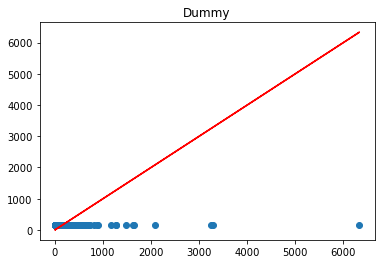

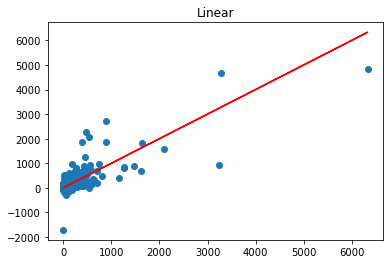

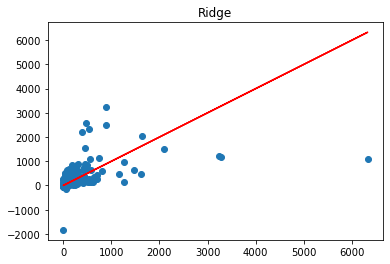

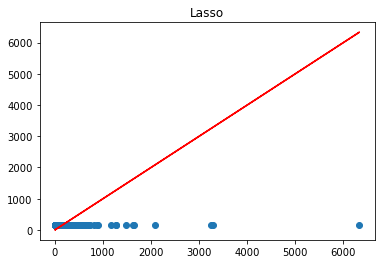

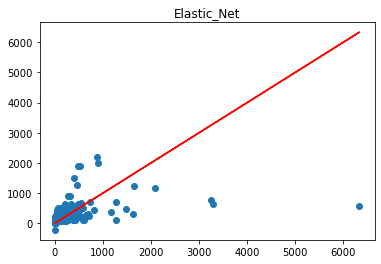

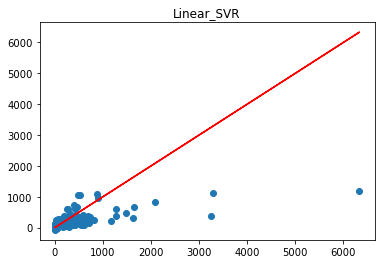

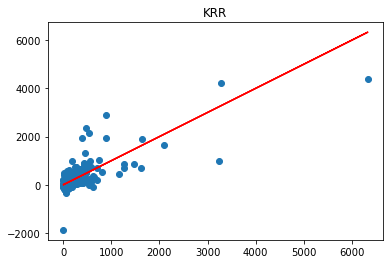

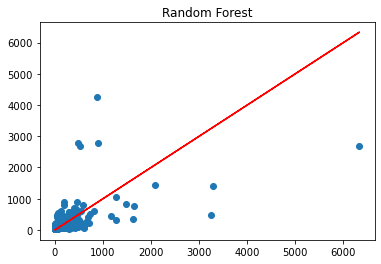

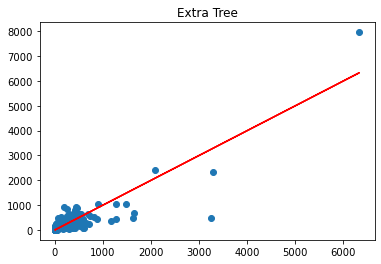

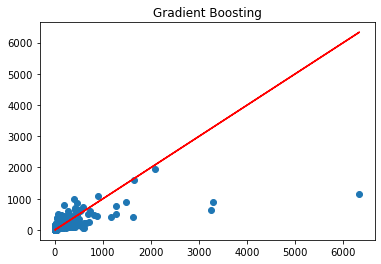

In [35]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result.iloc[:,:-2]

In [36]:
df_Result.iloc[:,:-1]

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s),best_params
Dummy,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.04,{}
Linear,0.66,0.54,367.123427,288.952362,134.966129,137.502695,0.04,{}
Ridge,0.40,0.09,488.010422,404.561187,145.536016,155.325444,0.39,{'alpha': 100.0}
Lasso,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.43,{'alpha': 464.15888336127773}
Elastic_Net,0.27,0.15,538.843274,390.839832,147.581722,147.695361,1.80,{'alpha': 1.0}
Linear_SVR,0.31,0.35,521.245268,341.130248,111.973465,106.299329,19.58,"{'C': 166.81005372000593, 'epsilon': 46.415888..."
KRR,0.66,0.50,369.178408,301.463837,137.774457,142.311080,2.59,{'gamma': 1e-20}
Random Forest,0.92,0.25,179.642974,367.971210,84.827414,131.575636,49.61,"{'max_depth': 5, 'n_estimators': 150}"
Extra Tree,0.97,0.73,102.002853,218.939972,56.677066,95.910990,459.53,"{'criterion': 'mse', 'max_depth': 8, 'n_estima..."
Gradient Boosting,0.96,0.40,130.275842,329.413587,70.138934,105.576498,1.51,{'n_estimators': 50}


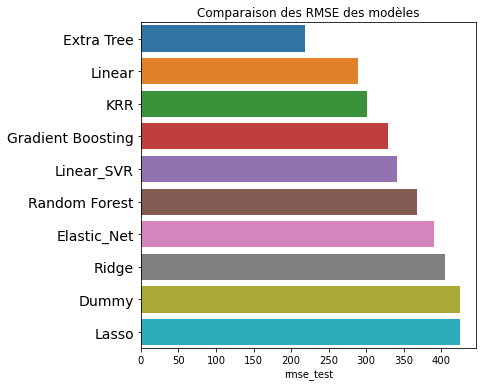

In [43]:
df_rmse_sort = pd.DataFrame(df_Result['rmse_test'].sort_values())
plt.figure(figsize=(6,6))
plt.title('Comparaison des RMSE des modèles')
ax = sns.barplot(y = df_rmse_sort.index , x = df_rmse_sort['rmse_test'])
ax.set_yticklabels(labels = df_rmse_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

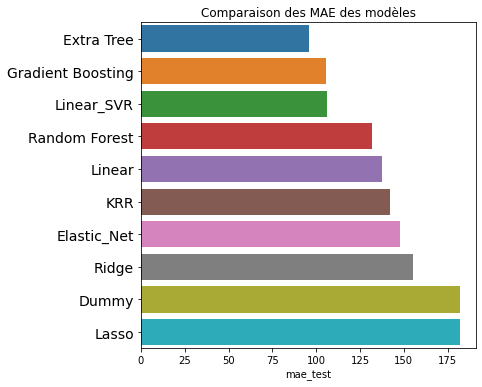

In [44]:
df_mae_sort = pd.DataFrame(df_Result['mae_test'].sort_values())
plt.figure(figsize=(6,6))
plt.title('Comparaison des MAE des modèles')
ax = sns.barplot(y = df_mae_sort.index , x = df_mae_sort['mae_test'])
ax.set_yticklabels(labels = df_mae_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

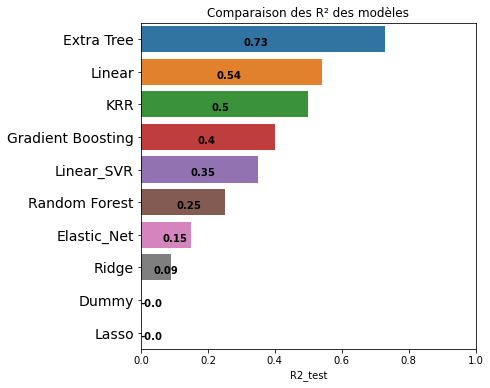

In [45]:
df_R2_sort = pd.DataFrame(df_Result['R2_test'].sort_values(ascending=False))
plt.figure(figsize=(6,6))
plt.title('Comparaison des R² des modèles')
ax = sns.barplot(y = df_R2_sort.index , x = df_R2_sort['R2_test'])
ax.set_yticklabels(labels = df_R2_sort.index, rotation=0, horizontalalignment='right',size=14)

for line in range(0,df_R2_sort.shape[0]):
     plt.text(df_R2_sort.R2_test[line]*0.42 , 0.2+line, df_R2_sort.R2_test[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set_xbound(0, 1)
plt.show()

Les meilleurs résultats en terme de R², RMSE et MAE sont obtenus avec l'algorithme ensembliste **ExtraTrees** avec les hyperparamètres suivants: {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}.

**Etude du temps d'exécution de chaque algorithme**

In [72]:
grid_params_best = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'alpha':[100]},#Ridge__alpha
                'Lasso'        : {'alpha':[464.15888336127773]},
                'Elastic_Net'  : {'alpha': [1]},
                'Linear_SVR'   : {'epsilon' :[46.41588833612782], 
                                 'C' : [166.81005372000593]},
                 'KRR'          : {'gamma' : [1e-20] },
                 'KNR'          : {'n_neighbors': [8]},
                 'Random Forest': {'max_depth': [5],
                                  'n_estimators': [150]},
                 'Extra Tree'    : {'n_estimators': [100],
                                  'criterion': ['mse'],
                                   'max_depth': [8]},# 
               'Gradient Boosting': {'n_estimators':[50]},
              } 

Dummy {}
Linear {}
Ridge {'alpha': 100}
Lasso {'alpha': 464.15888336127773}
Elastic_Net {'alpha': 1}
Linear_SVR {'C': 166.81005372000593, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
Random Forest {'max_depth': 5, 'n_estimators': 150}
Extra Tree {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}
Gradient Boosting {'n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,1.83
Linear,0.66,0.54,367.123427,288.952362,134.966129,137.502695,0.54
Ridge,0.40,0.09,488.010422,404.561187,145.536016,155.325444,0.15
Lasso,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.08
Elastic_Net,0.27,0.15,538.843274,390.839832,147.581722,147.695361,0.12
Linear_SVR,0.31,0.35,521.317246,341.144794,112.009006,106.305281,0.15
KRR,0.66,0.50,369.178408,301.463837,137.774457,142.311080,0.99
Random Forest,0.92,0.38,178.079465,335.093347,84.125623,123.798385,2.94
Extra Tree,0.97,0.74,103.218514,214.789899,56.604635,95.951046,1.92
Gradient Boosting,0.96,0.43,130.275842,319.314726,70.138934,104.519479,0.55


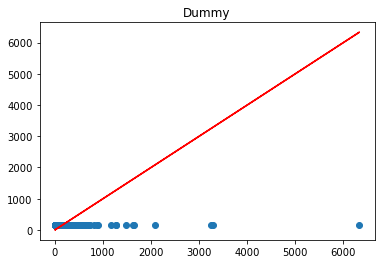

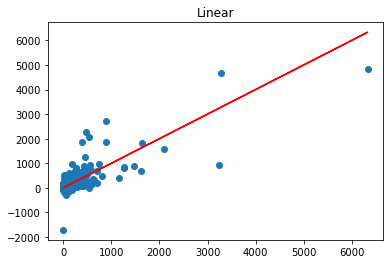

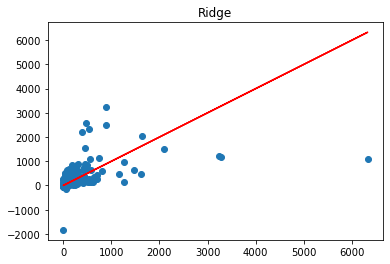

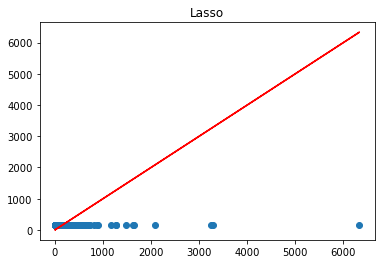

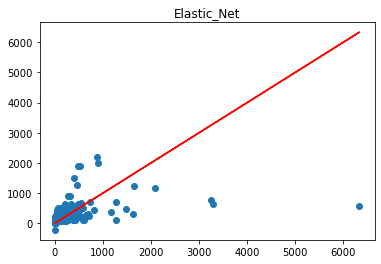

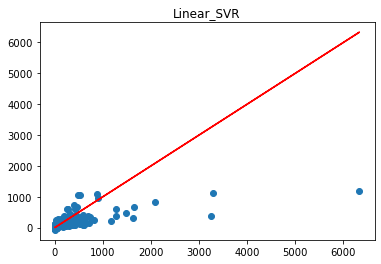

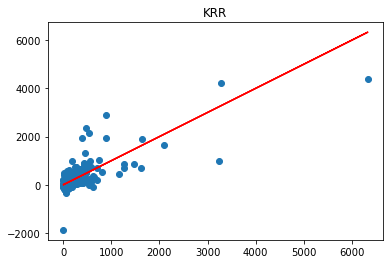

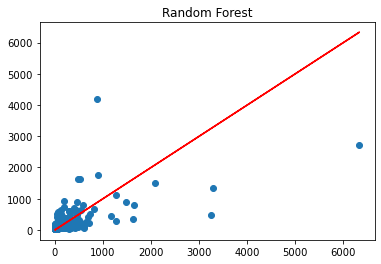

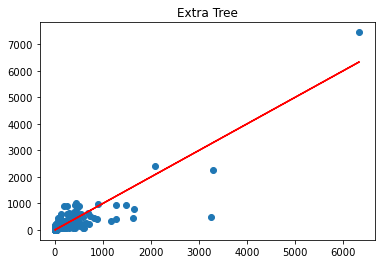

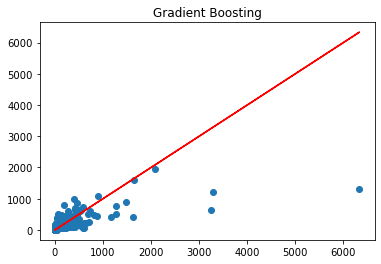

In [73]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result_best = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params_best[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result_best.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result_best.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result_best.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result_best.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result_best.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result_best.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result_best.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result_best.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result_best.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result_best.iloc[:,:-2]

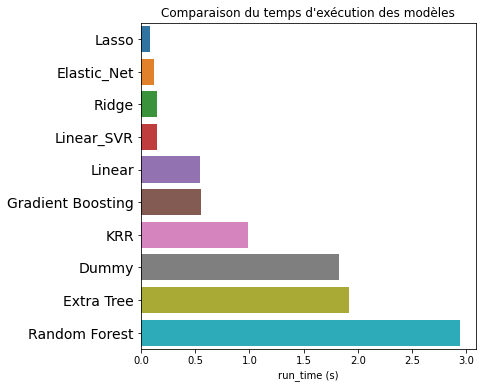

In [74]:
df_time_sort = pd.DataFrame(df_Result_best['run_time (s)'].sort_values())
plt.figure(figsize=(6,6))
plt.title("Comparaison du temps d'exécution des modèles")
ax = sns.barplot(y = df_time_sort.index , x = df_time_sort['run_time (s)'])
ax.set_yticklabels(labels = df_time_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

### Avec TransformedTargetRegressor

In [37]:
grid_params_log = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'regressor__alpha':np.logspace(0, 4, 10)},#Ridge__alpha
                'Lasso'        : {'regressor__alpha':np.logspace(0, 10, 10)},
                'Elastic_Net'  : {'regressor__alpha': np.logspace(-10, 10, 10)},
                'Linear_SVR'   : {'regressor__epsilon' : np.logspace(-10, 10, 10), 
                                 'regressor__C' : np.logspace(-10, 10, 10)},
                 'KNR'          : {'regressor__n_neighbors': np.arange(2, 10, 2)},
                 'KRR'          : {'regressor__gamma' : np.logspace(-10, 0, 10) },
                'Random Forest': {'regressor__max_depth': [10, 20, 30],
                                  'regressor__n_estimators': [10, 100, 150]},
               'Extra Tree'    : {'regressor__n_estimators': [10,50,100],
                                   'regressor__max_depth': [2,8,16]},
               'Gradient Boosting': {'regressor__n_estimators':[10,50,100], 
                                    'regressor__learning_rate': np.logspace(-5, 0, 10),
                                    'regressor__max_depth':[10, 20, 30] },
                        'XGBR': {'regressor__n_estimators':[10,50,100,500, 1000] }
              } 

Dummy {}
Linear {}
Ridge {'regressor__alpha': 1291.5496650148827}
Lasso {'regressor__alpha': 1.0}
Elastic_Net {'regressor__alpha': 12.915496650148826}
Linear_SVR {'regressor__C': 0.0004641588833612782, 'regressor__epsilon': 1e-10}
KRR {'regressor__gamma': 1e-10}
Random Forest {'regressor__max_depth': 20, 'regressor__n_estimators': 10}
Extra Tree {'regressor__max_depth': 16, 'regressor__n_estimators': 100}
Gradient Boosting {'regressor__learning_rate': 0.2782559402207126, 'regressor__max_depth': 10, 'regressor__n_estimators': 100}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s),best_params
Dummy,-0.04,-0.07,640.832597,438.567334,148.428949,139.515995,0.02,{}
Linear,-26.31,-13.65,3291.320153,1625.568938,224.193636,240.508906,0.07,{}
Ridge,0.05,-0.27,613.207793,478.985363,137.955987,139.277550,0.44,{'regressor__alpha': 1291.5496650148827}
Lasso,-0.04,-0.07,640.832597,438.567334,148.428949,139.515995,0.48,{'regressor__alpha': 1.0}
Elastic_Net,-0.04,-0.07,640.832597,438.567334,148.428949,139.515995,0.98,{'regressor__alpha': 12.915496650148826}
Linear_SVR,-0.07,-0.14,651.412994,452.965501,166.856476,157.792240,10.48,"{'regressor__C': 0.0004641588833612782, 'regre..."
KRR,-19.94,-15.46,2881.975821,1722.766374,210.942800,249.642346,2.45,{'regressor__gamma': 1e-10}
Random Forest,0.91,0.42,189.111078,324.466369,45.385363,98.084507,23.63,"{'regressor__max_depth': 20, 'regressor__n_est..."
Extra Tree,1.00,0.33,43.656302,348.819597,16.441944,95.783944,8.60,"{'regressor__max_depth': 16, 'regressor__n_est..."
Gradient Boosting,1.00,0.39,1.249447,331.339123,0.473752,105.658243,150.84,{'regressor__learning_rate': 0.278255940220712...


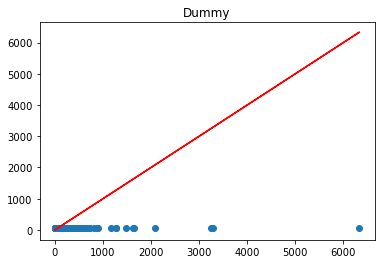

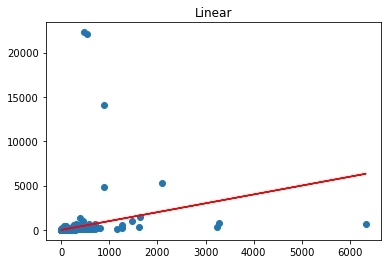

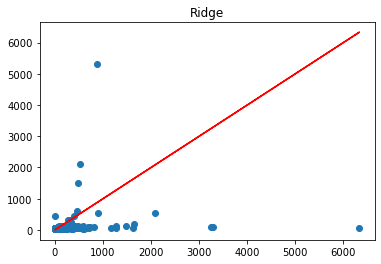

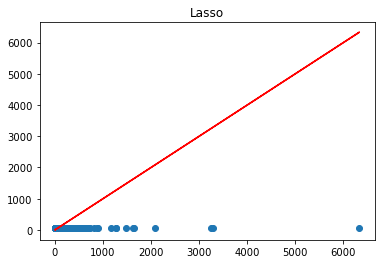

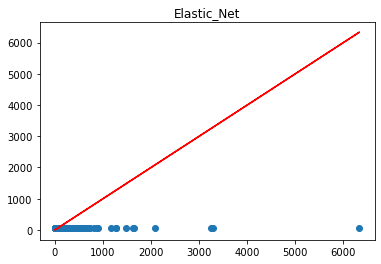

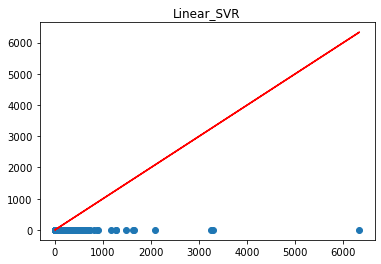

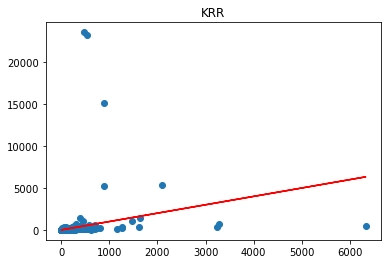

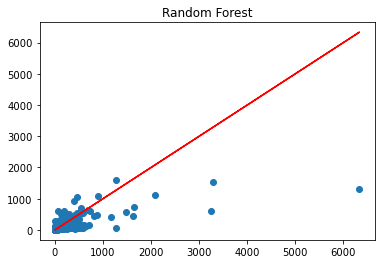

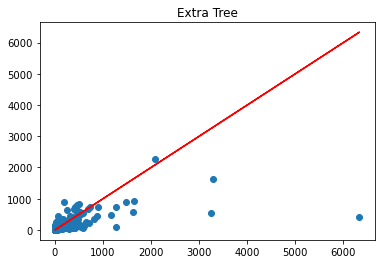

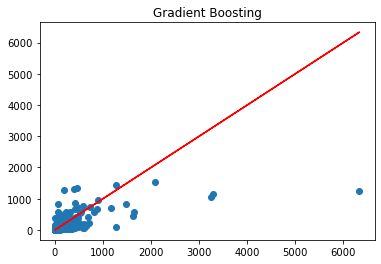

In [38]:
# Les regressors sont testés 1 à 1 
df_Result_log = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
    #reg = Pipeline(steps=[("preprocessor", preprocessor), (name_reg, reg)])
    start_time = timeit.default_timer()
    model =  GridSearchCV(TransformedTargetRegressor(regressor=reg, func=np.log, inverse_func=np.exp), grid_params_log[name_reg], cv=10) 
     
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result_log.loc[name_reg,'R2_train'] = round(model.score(X_train, y_train),2) # coéfficient de détermination
    df_Result_log.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result_log.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result_log.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result_log.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result_log.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
    
    df_Result_log.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result_log.loc[name_reg, 'best_params'] = str(model.best_params_)
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result_log

Le passage au log de notre variable target n'a pas amélioré les résultats de la prédiction au contraire ces dernières ont chuté très significativement.

# Influence du score 'ENERGY STAR Score'

In [41]:
# prétraitement
data = data_Seattle.copy()
data.drop(columns=['CouncilDistrictCode'], inplace=True)
dataE = data.dropna()
dataE.reset_index(drop=True, inplace=True)

# Encodage
categoricals = ['PrimaryPropertyType']#
dataE = pd.get_dummies(dataE, columns=categoricals, prefix=[''])


y = dataE['TotalGHGEmissions']
XE_ = dataE.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)# 'ENERGYSTARScore'


XE_train, XE_test, yE_train, yE_test = train_test_split(XE_, y, random_state=0, test_size=0.3)
# Rescale the input features
columns_to_scale = XE_.columns[:3]
coumns_not_to_scale = XE_.columns[3:]

scaler = StandardScaler()

XE_train_scaled_ = scaler.fit_transform(XE_train[columns_to_scale])
XE_test_scaled_ = scaler.transform(XE_test[columns_to_scale])

XE_train_scaled = pd.DataFrame(XE_train_scaled_, columns=columns_to_scale)
XE_test_scaled = pd.DataFrame(XE_test_scaled_, columns=columns_to_scale)

XE_train_not_to_scale = XE_train[coumns_not_to_scale]
XE_test_not_to_scale = XE_test[coumns_not_to_scale]

XE_train_not_to_scale.reset_index(inplace=True, drop=True)
XE_test_not_to_scale.reset_index(inplace=True, drop=True)

XE_train = pd.merge(XE_train_scaled, XE_train_not_to_scale, left_index =True, right_index = True)
XE_test = pd.merge(XE_test_scaled, XE_test_not_to_scale, left_index =True, right_index = True)

yE_train.reset_index(inplace=True, drop=True)
yE_test.reset_index(inplace=True, drop=True)


print('XE_train.shape = ', XE_train.shape)
print('yE_train.shape = ', yE_train.shape)
print('XE_test.shape = ' , XE_test.shape)
print('yE_test.shape = ', yE_test.shape)

XE_train.shape =  (688, 24)
yE_train.shape =  (688,)
XE_test.shape =  (295, 24)
yE_test.shape =  (295,)


Dummy {}
Linear {}
Ridge {'alpha': 100.0}
Lasso {'alpha': 100.0}
Elastic_Net {'alpha': 1.0}
Linear_SVR {'C': 12.91549665014884, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
Random Forest {'max_depth': 20, 'n_estimators': 100}
Extra Tree {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 120}
Gradient Boosting {'n_estimators': 10}


,R2_train_E,R2_test_E,rmse_train_E,rmse_test_E,mae_train_E,mae_test_E,run_time (s)_E
Dummy,0.00,-0.00,499.977292,990.544893,174.509940,238.238597,0.02
Linear,0.65,0.66,295.843198,577.345302,115.896266,155.098927,0.05
Ridge,0.26,0.27,430.091964,842.338059,130.734829,176.790515,0.38
Lasso,0.10,0.10,474.791198,937.869424,153.446935,209.662797,0.36
Elastic_Net,0.18,0.17,453.687266,899.868681,135.693866,187.226867,0.99
Linear_SVR,0.13,0.11,466.413194,929.697176,104.497910,165.210005,17.12
KRR,0.64,0.64,300.264676,596.509453,119.298461,155.628297,1.09
Random Forest,0.93,0.65,128.545274,587.159844,35.360629,126.453335,40.55
Extra Tree,0.97,0.71,85.499428,530.437811,37.984766,121.593133,221.92
Gradient Boosting,0.78,0.59,234.389702,630.713378,110.251419,159.678010,1.40


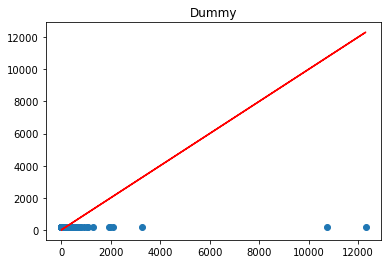

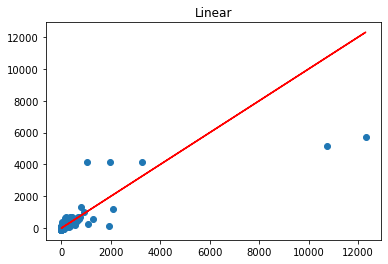

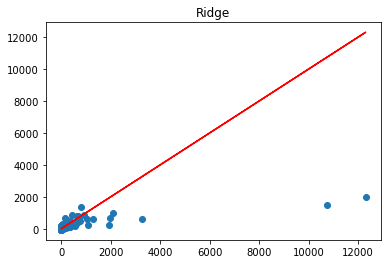

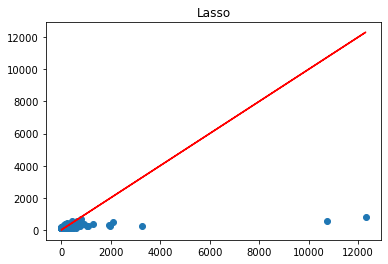

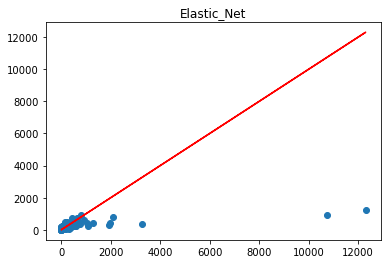

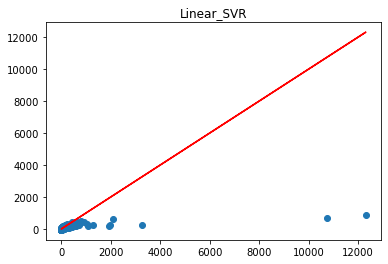

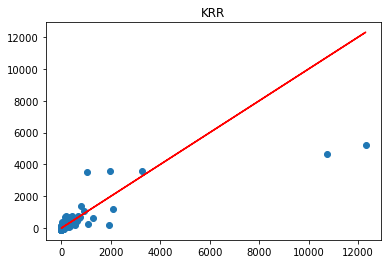

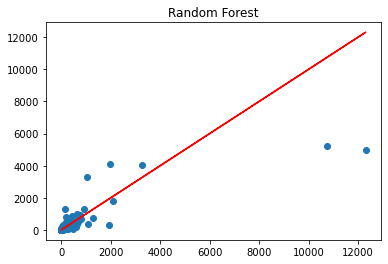

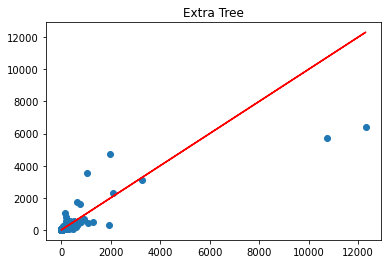

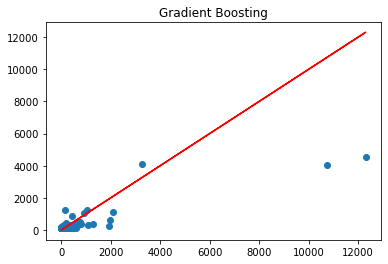

In [42]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result_E = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    modelE =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    modelE.fit(XE_train, yE_train)

    y_pred_test = modelE.predict(XE_test)
    y_pred_train = modelE.predict(XE_train)

    # calcul de l'erreur
    df_Result_E.loc[name_reg,'R2_train_E'] = round(metrics.r2_score(yE_train, y_pred_train),2) # coéfficient de détermination
    df_Result_E.loc[name_reg,'R2_test_E'] = round(metrics.r2_score(yE_test, y_pred_test),2)
    
    df_Result_E.loc[name_reg, 'rmse_train_E'] = np.sqrt(metrics.mean_squared_error(yE_train, y_pred_train))
    df_Result_E.loc[name_reg, 'rmse_test_E'] = np.sqrt(metrics.mean_squared_error(yE_test, y_pred_test))
    
    df_Result_E.loc[name_reg, 'mae_train_E'] = metrics.mean_absolute_error(yE_train, y_pred_train)
    df_Result_E.loc[name_reg, 'mae_test_E'] = metrics.mean_absolute_error(yE_test, y_pred_test)
 
    df_Result_E.loc[name_reg, 'run_time (s)_E'] = round(timeit.default_timer() - start_time,2)
    df_Result_E.loc[name_reg, 'best_params_E'] = str(modelE.best_params_)
    df_Result_E.loc[name_reg,'Model_dic_E'] = modelE
    
    print(name_reg, str(modelE.best_params_) )
    plt.figure()
    plt.scatter(yE_test, y_pred_test)
    plt.plot(yE_test, yE_test , 'r-')
    plt.title(name_reg) 

df_Result_E.iloc[:,:-2]

Dummy {}
Linear {}
Ridge {'alpha': 100.0}
Lasso {'alpha': 464.15888336127773}
Elastic_Net {'alpha': 1.0}
Linear_SVR {'C': 166.81005372000593, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
Random Forest {'max_depth': 10, 'n_estimators': 100}
Extra Tree {'criterion': 'mse', 'max_depth': 8, 'n_estimators': 120}
Gradient Boosting {'n_estimators': 100}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.03
Linear,0.66,0.54,367.123427,288.952362,134.966129,137.502695,0.04
Ridge,0.40,0.09,488.010422,404.561187,145.536016,155.325444,0.37
Lasso,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.40
Elastic_Net,0.27,0.15,538.843274,390.839832,147.581722,147.695361,1.80
Linear_SVR,0.32,0.35,521.163444,341.090248,111.909047,106.251894,19.04
KRR,0.66,0.50,369.178408,301.463837,137.774457,142.311080,2.62
Random Forest,0.96,0.48,122.839864,305.128494,53.055985,109.982901,50.04
Extra Tree,0.98,0.72,99.550399,225.202997,55.704292,99.369560,477.70
Gradient Boosting,0.97,0.44,104.686710,317.327775,58.875128,104.275767,1.74


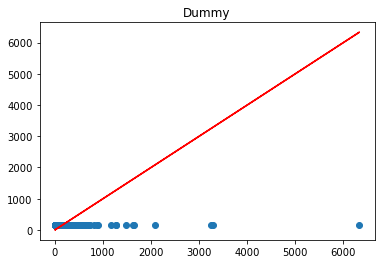

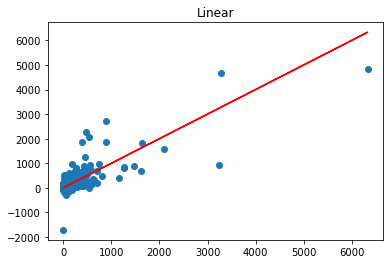

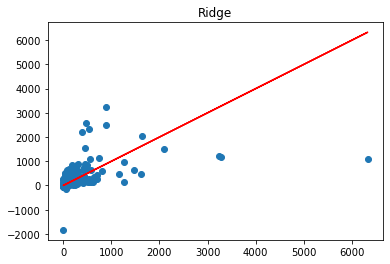

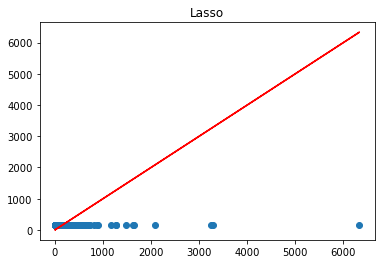

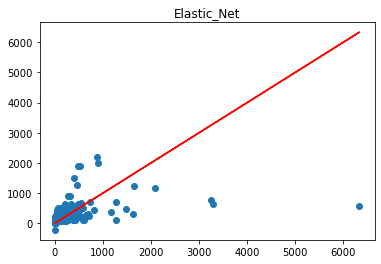

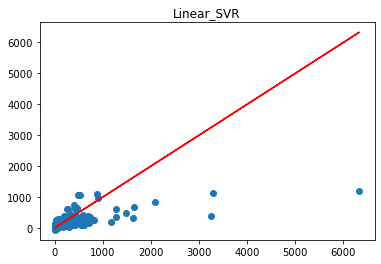

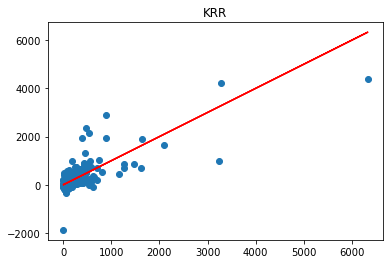

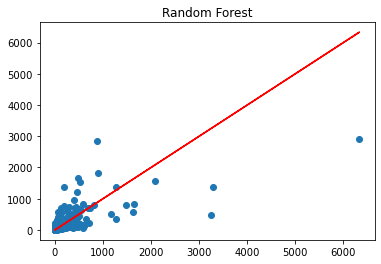

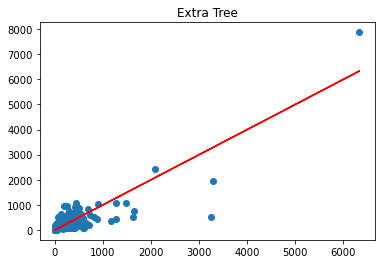

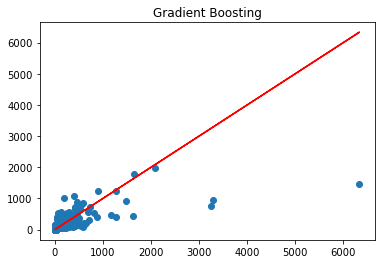

In [49]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result.iloc[:,:-2]

In [50]:
display(df_Result_E.iloc[:,:-2])
display(df_Result.iloc[:,:-2])

,R2_train_E,R2_test_E,rmse_train_E,rmse_test_E,mae_train_E,mae_test_E,run_time (s)_E
Dummy,0.00,-0.00,499.977292,990.544893,174.509940,238.238597,0.02
Linear,0.65,0.66,295.843198,577.345302,115.896266,155.098927,0.05
Ridge,0.26,0.27,430.091964,842.338059,130.734829,176.790515,0.38
Lasso,0.10,0.10,474.791198,937.869424,153.446935,209.662797,0.36
Elastic_Net,0.18,0.17,453.687266,899.868681,135.693866,187.226867,0.99
Linear_SVR,0.13,0.11,466.413194,929.697176,104.497910,165.210005,17.12
KRR,0.64,0.64,300.264676,596.509453,119.298461,155.628297,1.09
Random Forest,0.93,0.65,128.545274,587.159844,35.360629,126.453335,40.55
Extra Tree,0.97,0.71,85.499428,530.437811,37.984766,121.593133,221.92
Gradient Boosting,0.78,0.59,234.389702,630.713378,110.251419,159.678010,1.40


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.03
Linear,0.66,0.54,367.123427,288.952362,134.966129,137.502695,0.04
Ridge,0.40,0.09,488.010422,404.561187,145.536016,155.325444,0.37
Lasso,0.00,-0.00,629.771874,424.776008,193.084420,181.931111,0.40
Elastic_Net,0.27,0.15,538.843274,390.839832,147.581722,147.695361,1.80
Linear_SVR,0.32,0.35,521.163444,341.090248,111.909047,106.251894,19.04
KRR,0.66,0.50,369.178408,301.463837,137.774457,142.311080,2.62
Random Forest,0.96,0.48,122.839864,305.128494,53.055985,109.982901,50.04
Extra Tree,0.98,0.72,99.550399,225.202997,55.704292,99.369560,477.70
Gradient Boosting,0.97,0.44,104.686710,317.327775,58.875128,104.275767,1.74


In [53]:
df_R2_sort = pd.DataFrame(df_Result['R2_test'].sort_values(ascending=False))
df_R2_sort['R2_test_E'] = df_Result_E['R2_test_E']
display(df_R2_sort)

,R2_test,R2_test_E
Extra Tree,0.72,0.71
Linear,0.54,0.66
KRR,0.50,0.64
Random Forest,0.48,0.65
Gradient Boosting,0.44,0.59
Linear_SVR,0.35,0.11
Elastic_Net,0.15,0.17
Ridge,0.09,0.27
Dummy,-0.00,-0.00
Lasso,-0.00,0.10


In [68]:
df_R2_sort = pd.DataFrame(df_Result['R2_test'].sort_values(ascending=False))
df_R2_sort['R2_test_E'] = df_Result_E['R2_test_E']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['R2_test'],
    name='Sans ENERGYSTARScore',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['R2_test_E'],
    name='Avec ENERGYSTARScore',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparaison des R² des modèles')

fig.show()

In [69]:
df_R2_sort = pd.DataFrame(df_Result['rmse_test'].sort_values())
df_R2_sort['rmse_test_E'] = df_Result_E['rmse_test_E']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['rmse_test'],
    name='Sans ENERGYSTARScore',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['rmse_test_E'],
    name='Avec ENERGYSTARScore',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparaison des RMSE des modèles')

fig.show()

In [70]:
df_R2_sort = pd.DataFrame(df_Result['mae_test'].sort_values())
df_R2_sort['mae_test_E'] = df_Result_E['mae_test_E']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['mae_test'],
    name='Sans ENERGYSTARScore',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=df_R2_sort.index,
    y=df_R2_sort['mae_test_E'],
    name='Avec ENERGYSTARScore',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparaison des MAE des modèles')

fig.show()

L ’ENERGYSTARScore n’est intéressant pour la prédiction des émissions.

# Modèle final

Modèle final choisi pour la prédiction de l'énergie: **ExtraTreesRegressor(criterion= 'mse', max_depth= 8, n_estimators= 100)** .

L'ExtraTrees est l'algorithme qui donne les meilleurs performances en terme de R², RMSE et MAE. Le seul inconvénient est qu'il prend plus de temps d'exécution par rapport aux autres algorithmes puisqu'il est ensembliste.

In [47]:
# Create final model
name_reg = 'Extra Tree'
model_final = ExtraTreesRegressor(criterion= 'mse', max_depth= 8, n_estimators= 100)

# Fit model
model_final.fit(X_train, y_train)

# Prediction
y_pred_test = model_final.predict(X_test)
y_pred_train = model_final.predict(X_train)

# Evaluate
dff_Result = pd.DataFrame({})
dff_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
dff_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)

dff_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
dff_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

dff_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
dff_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)

dff_Result

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test
Extra Tree,0.97,0.74,101.193228,214.507756,56.261865,95.942401


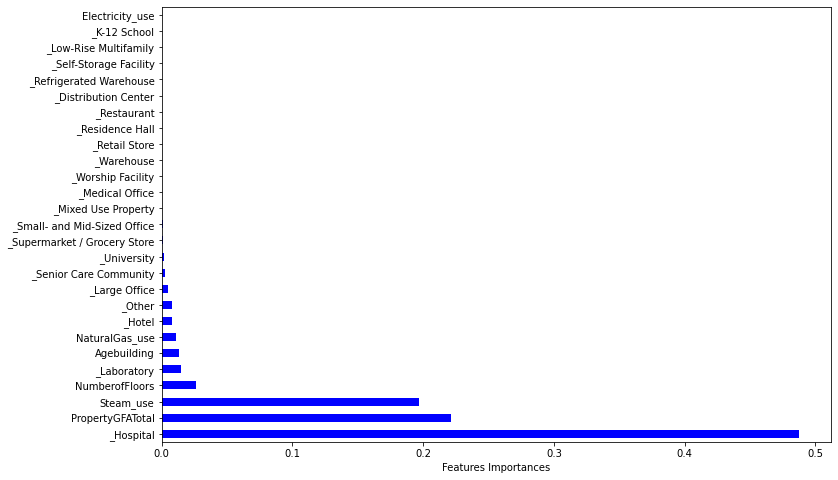

In [48]:
features_importances = pd.Series(model_final.feature_importances_, index=X_train.columns)
plt.figure(figsize=(12,8))
features_importances.nlargest(30).plot(kind='barh', color='b')

plt.xlabel('Features Importances')
plt.show()

Les variables les plus importantes pour notre modèle de prédiction des émissions sont: 
* la surface
* le nombre d'étage 
* les catégories Hôpital et laboratoire
* utilisation de la vapeur comme énergie
* l'âge du bâtiment 